<a href="https://colab.research.google.com/github/nehasingh7156/Predictive-Disease-Outbreak-Dashboard/blob/main/Predictive_Disease_Outburst_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install xgboost statsmodels

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

print("Environment ready")

Environment ready


In [3]:
from google.colab import files
uploaded = files.upload()

Saving water_dataX.csv to water_dataX.csv


In [4]:
from google.colab import files
uploaded = files.upload()

Saving typhoid_india_data .csv to typhoid_india_data .csv


In [7]:
hospital = pd.read_csv("typhoid_india_data .csv")
water = pd.read_csv("water_dataX.csv",encoding='latin1')

hospital.head()
water.head()

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [8]:
import os
os.listdir()


['.config', 'typhoid_india_data .csv', 'water_dataX.csv', 'sample_data']

In [9]:
water.head()


,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [10]:
hospital.head()

,Patient_ID,Name,Age,Gender,State,City,Date_Reported,Symptoms,Hospitalized,Days_Hospitalized,...,Ward_Number,Blood_Test_Result,Widal_Test_Result,Temperature_At_Admission,White_Blood_Cell_Count,Platelet_Count,Previous_History_Typhoid,Water_Source,Sanitation_Level,Health_Education_Level
0,TYP100000,Patient_0,52,Female,Punjab,City_328,01-01-2004,"Weakness, Constipation, Diarrhea, Headache",True,0,...,15,Positive,Positive,101.1,7841,164812,True,Tank,Good,Low
1,TYP100001,Patient_1,15,Other,Maharashtra,City_58,16-08-2004,"Abdominal Pain, Headache, Fever",False,2,...,9,Positive,Positive,100.0,8700,110316,False,Borewell,Poor,Medium
2,TYP100002,Patient_2,72,Other,Chhattisgarh,City_13,14-02-2004,"Constipation, Weakness, Headache, Fever, Diarrhea",False,0,...,3,Positive,Positive,99.5,10497,166871,True,Tank,Poor,Medium
3,TYP100003,Patient_3,61,Other,Uttar Pradesh,City_380,19-02-2003,"Weakness, Diarrhea, Loss of Appetite, Abdomina...",False,12,...,9,Positive,Negative,100.4,9786,227719,False,Tank,Good,Low
4,TYP100004,Patient_4,21,Female,Himachal Pradesh,City_141,20-02-2003,"Abdominal Pain, Constipation",True,4,...,18,Positive,Positive,102.0,7691,230092,False,Borewell,Moderate,Low


In [11]:
hospital['Date_Reported'] = pd.to_datetime(
    hospital['Date_Reported'],
    errors='coerce'
)

hospital = hospital.dropna(subset=['Date_Reported'])

hospital_daily = (
    hospital.groupby('Date_Reported')
    .size()
    .reset_index(name='daily_cases')
    .sort_values('Date_Reported')
)

hospital_daily.head()

,Date_Reported,daily_cases
0,2002-01-02,1
1,2002-01-03,1
2,2002-01-04,1
3,2002-01-05,1
4,2002-01-06,1


In [12]:
water.columns = water.columns.str.strip()

numeric_cols = [
    'Temp','D.O. (mg/l)','PH',
    'CONDUCTIVITY (µmhos/cm)',
    'B.O.D. (mg/l)',
    'FECAL COLIFORM (MPN/100ml)'
]

for col in numeric_cols:
    water[col] = pd.to_numeric(water[col], errors='coerce')

water = water.fillna(water.mean(numeric_only=True))

water['date'] = pd.to_datetime(water['year'], format='%Y')
water = water.sort_values('date')

water.head()

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,date
1990,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01
1926,17,"PERIYAR AT ALWAYE, KERALA",NAN,28.0,6.4,1579.0,5.8,1.7,0.513,0.513000,959,2003,2003-01-01
1927,18,"PERIYAR AT KALADY, KERALA",NAN,27.0,6.8,62.0,7.5,1.5,0.221,0.221000,892,2003,2003-01-01
1928,1338,"PERIYAR AT SEWAGE DISCHARGE POINT, KERALA",NAN,28.0,6.9,44.0,6.8,1.0,0.151,0.151000,734,2003,2003-01-01
1929,20,"CHALIYAR AT KOOLIMADU, KERALA",NAN,28.0,6.9,62.0,6.8,0.4,0.21,0.210000,802,2003,2003-01-01


In [13]:
merged = pd.merge_asof(
    hospital_daily.sort_values('Date_Reported'),
    water.sort_values('date'),
    left_on='Date_Reported',
    right_on='date',
    direction='nearest'
)

merged.head()

,Date_Reported,daily_cases,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,date
0,2002-01-02,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01
1,2002-01-03,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01
2,2002-01-04,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01
3,2002-01-05,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01
4,2002-01-06,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01


In [14]:
merged['lag_1'] = merged['daily_cases'].shift(1)
merged['lag_7'] = merged['daily_cases'].shift(7)

merged['rolling_mean_7'] = merged['daily_cases'].rolling(7).mean()

merged['month'] = merged['Date_Reported'].dt.month
merged['dayofweek'] = merged['Date_Reported'].dt.dayofweek

merged = merged.dropna()
merged.head()

,Date_Reported,daily_cases,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year,date,lag_1,lag_7,rolling_mean_7,month,dayofweek
7,2002-02-03,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01,1.0,1.0,1.0,2,6
8,2002-02-04,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01,1.0,1.0,1.0,2,0
9,2002-02-05,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01,1.0,1.0,1.0,2,1
10,2002-02-06,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01,1.0,1.0,1.0,2,2
11,2002-02-07,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,NAN,362529.364718,546,2003,2003-01-01,1.0,1.0,1.0,2,3


In [15]:
features = merged[['daily_cases','lag_1','rolling_mean_7']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

iso = IsolationForest(contamination=0.05)
merged['anomaly'] = iso.fit_predict(X_scaled)

merged['anomaly_flag'] = merged['anomaly'].map({1:0,-1:1})

merged.head()

,Date_Reported,daily_cases,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),...,TOTAL COLIFORM (MPN/100ml)Mean,year,date,lag_1,lag_7,rolling_mean_7,month,dayofweek,anomaly,anomaly_flag
7,2002-02-03,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,546,2003,2003-01-01,1.0,1.0,1.0,2,6,1,0
8,2002-02-04,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,546,2003,2003-01-01,1.0,1.0,1.0,2,0,1,0
9,2002-02-05,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,546,2003,2003-01-01,1.0,1.0,1.0,2,1,1,0
10,2002-02-06,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,546,2003,2003-01-01,1.0,1.0,1.0,2,2,1,0
11,2002-02-07,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,546,2003,2003-01-01,1.0,1.0,1.0,2,3,1,0


In [16]:
series = merged.set_index('Date_Reported')['daily_cases']

train = series[:-48]
test = series[-48:]

model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,7))
results = model.fit()

forecast = results.forecast(48)

In [17]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.00841538078667465
RMSE: 0.010333806786754156


In [18]:
threshold_high = merged['daily_cases'].quantile(0.9)
threshold_mid = merged['daily_cases'].quantile(0.6)

def classify_risk(x):
    if x >= threshold_high: return "High"
    elif x >= threshold_mid: return "Medium"
    return "Low"

merged['risk_level'] = merged['daily_cases'].apply(classify_risk)

merged.head()

,Date_Reported,daily_cases,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),...,year,date,lag_1,lag_7,rolling_mean_7,month,dayofweek,anomaly,anomaly_flag,risk_level
7,2002-02-03,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,6,1,0,Medium
8,2002-02-04,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,0,1,0,Medium
9,2002-02-05,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,1,1,0,Medium
10,2002-02-06,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,2,1,0,Medium
11,2002-02-07,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,3,1,0,Medium


In [19]:
merged.to_csv("prepared_outbreak_dataset.csv", index=False)

from google.colab import files
files.download("prepared_outbreak_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
!pip install xgboost

import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv("prepared_outbreak_dataset.csv")

df['Date_Reported'] = pd.to_datetime(df['Date_Reported'])
df = df.sort_values('Date_Reported')

df.head()

,Date_Reported,daily_cases,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),...,year,date,lag_1,lag_7,rolling_mean_7,month,dayofweek,anomaly,anomaly_flag,risk_level
0,2002-02-03,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,6,1,0,Medium
1,2002-02-04,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,0,1,0,Medium
2,2002-02-05,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,1,1,0,Medium
3,2002-02-06,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,2,1,0,Medium
4,2002-02-07,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,3,1,0,Medium


In [22]:
# Lag features
for lag in [1, 2, 3, 7, 14]:
    df[f'lag_{lag}'] = df['daily_cases'].shift(lag)

# Rolling stats
df['roll_mean_7'] = df['daily_cases'].rolling(7).mean()
df['roll_std_7'] = df['daily_cases'].rolling(7).std()

# Calendar features
df['dayofweek'] = df['Date_Reported'].dt.dayofweek
df['month'] = df['Date_Reported'].dt.month

df = df.dropna()
df.head()

,Date_Reported,daily_cases,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),...,month,dayofweek,anomaly,anomaly_flag,risk_level,lag_2,lag_3,lag_14,roll_mean_7,roll_std_7
14,2002-04-05,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,4,4,1,0,Medium,1.0,1.0,1.0,1.0,0.0
15,2002-04-06,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,4,5,1,0,Medium,1.0,1.0,1.0,1.0,0.0
16,2002-04-07,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,4,6,1,0,Medium,1.0,1.0,1.0,1.0,0.0
17,2002-05-02,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,5,3,1,0,Medium,1.0,1.0,1.0,1.0,0.0
18,2002-05-03,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,5,4,1,0,Medium,1.0,1.0,1.0,1.0,0.0


In [23]:
HORIZON = 48

df['target'] = df['daily_cases'].shift(-HORIZON)
df = df.dropna()

In [26]:
# Keep only numeric columns
X = df.select_dtypes(include=[np.number]).drop(columns=['target'])

y = df['target']

split = int(len(df) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Features used:")
print(X.columns)

Features used:
Index(['daily_cases', 'Temp', 'D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)',
       'B.O.D. (mg/l)', 'FECAL COLIFORM (MPN/100ml)', 'year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'month', 'dayofweek', 'anomaly', 'anomaly_flag',
       'lag_2', 'lag_3', 'lag_14', 'roll_mean_7', 'roll_std_7'],
      dtype='object')


In [27]:
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [28]:
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.12665727849823336
RMSE: 0.18613509425795682


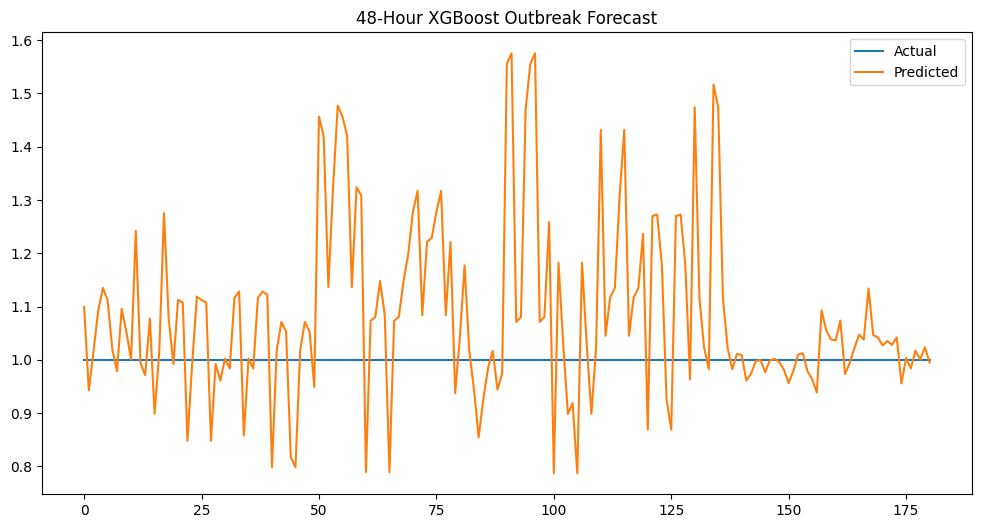

In [29]:
plt.figure(figsize=(12,6))

plt.plot(y_test.values, label="Actual")
plt.plot(preds, label="Predicted")

plt.title("48-Hour XGBoost Outbreak Forecast")
plt.legend()
plt.show()

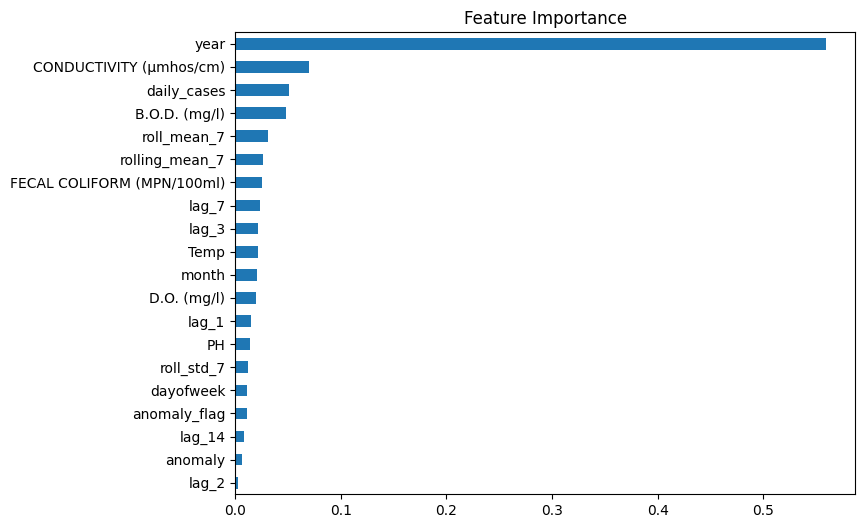

In [30]:
importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values()

importance.plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance")
plt.show()

In [31]:
!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [32]:
df = pd.read_csv("prepared_outbreak_dataset.csv")

df['Date_Reported'] = pd.to_datetime(df['Date_Reported'])
df = df.sort_values('Date_Reported')

series = df['daily_cases'].values.reshape(-1,1)

df.head()

,Date_Reported,daily_cases,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),...,year,date,lag_1,lag_7,rolling_mean_7,month,dayofweek,anomaly,anomaly_flag,risk_level
0,2002-02-03,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,6,1,0,Medium
1,2002-02-04,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,0,1,0,Medium
2,2002-02-05,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,1,1,0,Medium
3,2002-02-06,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,2,1,0,Medium
4,2002-02-07,1,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",NAN,29.0,7.6,110.0,5.7,1.1,...,2003,2003-01-01,1.0,1.0,1.0,2,3,1,0,Medium


In [34]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series)

In [35]:
WINDOW = 14
HORIZON = 48

X, y = [], []

for i in range(len(scaled) - WINDOW - HORIZON):
    X.append(scaled[i:i+WINDOW])
    y.append(scaled[i+WINDOW+HORIZON])

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(905, 14, 1) (905, 1)


In [36]:
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [37]:
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(WINDOW,1)),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test)
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0531 - val_loss: 0.0126
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0614 - val_loss: 0.0111
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0657 - val_loss: 0.0076
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0633 - val_loss: 0.0061
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0609 - val_loss: 0.0093
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0553 - val_loss: 0.0116
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0583 - val_loss: 0.0091
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0626 - val_loss: 0.0090
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0610 - val_loss: 0.0077
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0563 - val_loss: 0.0054
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0624 - val_loss: 0.0085
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

In [39]:
preds = model.predict(X_test)

preds = scaler.inverse_transform(preds)
actual = scaler.inverse_transform(y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


In [40]:
mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.15095792159191151
RMSE: 0.1510818218021448


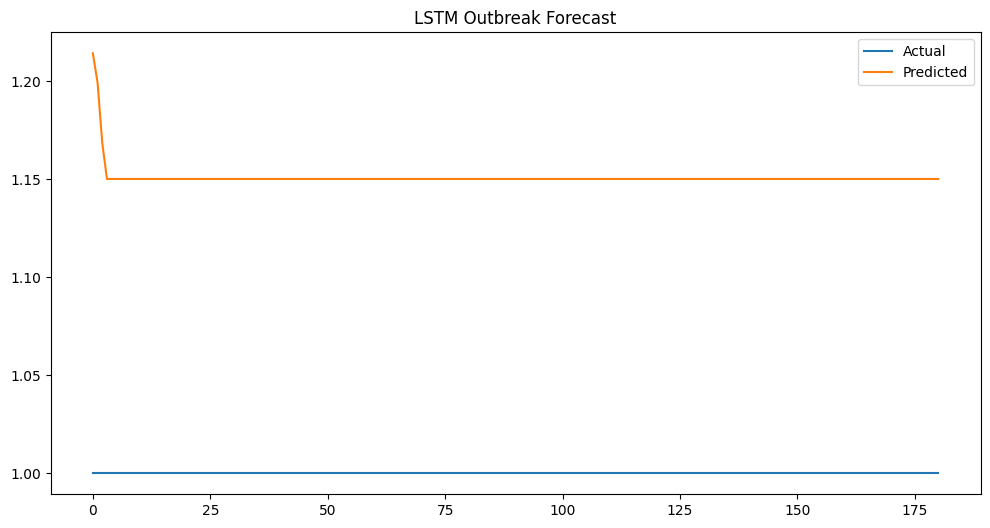

In [41]:
plt.figure(figsize=(12,6))

plt.plot(actual, label="Actual")
plt.plot(preds, label="Predicted")

plt.title("LSTM Outbreak Forecast")
plt.legend()
plt.show()